In this competition your task will be to predict the price of flats in test.csv. You will be given two datasets: train.csv (contains all features and prices of flats) and test.csv (only features).

## Load Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'Vitalii_Ikoev_predictions.csv'
print("Data is successfully loaded!")

Data is successfully loaded!


Convert categorical variables to booleans (only if we get two values)

In [3]:
def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

Display a scatter chart

In [4]:
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

Removing outliers from the sample and replacing them with the mean value

In [5]:
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [6]:
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

Fills in the blank values of the LifeSquare attribute, calculating it using the total area of the apartment, and replacing the outliers of the HouseYear feature with the mean value

In [7]:
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [8]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2025, 'HouseYear'] = mean_year

Calculating the r2_score and mae from the passed datasets and model

In [9]:
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

Memory optimization

In [10]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [11]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [12]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A

In [14]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Memory use optimization

In [15]:
df_train['Rooms'] = df_train['Rooms'].astype('int64')
df_test['Rooms'] = df_test['Rooms'].astype('int64')

In [16]:
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int64')
df_test['HouseFloor'] = df_test['HouseFloor'].astype('int64')

In [17]:
train_opt = optimizing_df(df_train)
test_opt = optimizing_df(df_test)

In [18]:
train_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [19]:
test_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

## Data  quality check

### Training

In [20]:
train_opt.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315712    37.199596   
std     4859.01902     43.587592      0.839512     21.058718    86.241112   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774879    22.769833   
50%     8394.50000     36.000000      2.000000     52.513309    32.781261   
75%    12592.50000     75.000000      2.000000     65.900627    45.128803   
max    16798.00000    209.000000     19.000000    641.065186  7480.592285   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.561113      5.241148      6.775974  2.005003e+05      0.119026   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904419      1.319500   
std       17.532614   4006.799803     23.831875   1021.518982      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214139.218750  
std        4.806341   92872.304688  
min        0.000000   59174.777344  
25%        1.000000  153872.628906  
50%        3.000000  192269.648438  
75%        6.000000  249135.460938  
max       23.000000  633233.437500

LifeSquare and Square values look a bit too different, let's have a look if there are outliners and fix them.

In [21]:
train_opt['LifeSquare'].describe()

count    7887.000000
mean       37.199596
std        86.241112
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [22]:
train_opt['Square'].describe()

count    10000.000000
mean        56.315712
std         21.058718
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

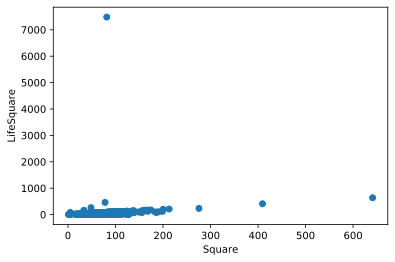

In [23]:
draw_scatter('Square', 'LifeSquare', train_opt)

In [24]:
train_opt.loc[train_opt['Square'] > 200].nlargest(20, 'Square')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
6977  11602          30      2  641.065186  638.163208           10.0     20   
4262     28           9      2  604.705994         NaN            1.0     17   
4690   2307         102      1  409.425171  410.639740           10.0      4   
1982   5548          86      5  275.645294  233.949310           26.0     12   
1981   7917          27      0  212.932358  211.231125            0.0      2   
9910  16568          27      4  200.334534  201.627365           25.0      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
6977          19       2019   0.000078         B         B        22   
4262          18       1977   0.161532         B         B        25   
4690           4       2016   0.238617         B         B        26   
1982          37       2011   0.161976         B         A        31   
1981           3       2008   0.211401         B         B         9   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
6977      6398       141        1046.0            3       23       B   
4262      5648         1          30.0            2        4       B   
4690      3889         6         705.0            3        6       B   
1982      7010         5        4508.0            3        7       B   
1981      1892         0           NaN            0        1       B   
9910     14892         4           NaN            1        4       B   

              Price  
6977  133529.687500  
4262  187717.250000  
4690   90470.429688  
1982  455264.875000  
1981  302211.250000  
9910  528560.500000

Indeed, sample has outlines that should be fixed.

In [25]:
drop_by_IQ('Square', train_opt)

For column Square
	IQ:	24.125747680664062
	LOW:	5.5862579345703125
	HIGH:	102.08924865722656

Lost 2.42% of data.


In [26]:
drop_by_IQ('LifeSquare', train_opt)

For column LifeSquare
	IQ:	21.756927490234375
	LOW:	-9.940135955810547
	HIGH:	77.08757400512695

Lost 1.91% of data.


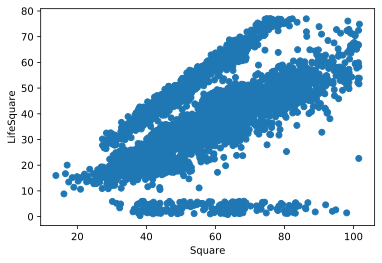

In [27]:
draw_scatter('Square', 'LifeSquare', train_opt)

In [28]:
train_opt.loc[train_opt['Square'] > 200].nlargest(20, 'Square')

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price]
Index: []

We got rid of outliners. But the number of missing values in LifeSquare is also disturbing, let's fix it with using mean values.

In [29]:
square_mean_values = train_opt[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378518

In [30]:
fill_life_square(train_opt, square_coeff)

In [31]:
train_opt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9572 non-null   uint16  
 1   DistrictId     9572 non-null   uint8   
 2   Rooms          9572 non-null   uint8   
 3   Square         9572 non-null   float32 
 4   LifeSquare     9572 non-null   float32 
 5   KitchenSquare  9572 non-null   float32 
 6   Floor          9572 non-null   uint8   
 7   HouseFloor     9572 non-null   uint8   
 8   HouseYear      9572 non-null   uint32  
 9   Ecology_1      9572 non-null   float32 
 10  Ecology_2      9572 non-null   category
 11  Ecology_3      9572 non-null   category
 12  Social_1       9572 non-null   uint8   
 13  Social_2       9572 non-null   uint16  
 14  Social_3       9572 non-null   uint8   
 15  Healthcare_1   5025 non-null   float32 
 16  Helthcare_2    9572 non-null   uint8   
 17  Shops_1        9572 non-null   ui

In [32]:
train_opt.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118824    34.519817   
std     4856.596405    43.768356     0.809624    15.594494    13.030704   
min        2.000000     0.000000     0.000000    13.784864     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065817   
50%     8390.500000    36.000000     2.000000    51.217516    32.871721   
75%    12591.250000    77.000000     2.000000    64.293636    43.319538   
max    16798.000000   209.000000    19.000000   102.032799    77.052979   

       KitchenSquare        Floor   HouseFloor     HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9.572000e+03  9572.000000   
mean        6.243105     8.471061    12.586293  4.079251e+03     0.119943   
std        29.064854     5.168552     6.628252  2.049338e+05     0.119591   
min         0.000000     1.000000     0.000000  1.910000e+03     0.000000   
25%         1.000000     4.000000     9.000000  1.973000e+03     0.017647   
50%         6.000000     7.000000    12.000000  1.977000e+03     0.075779   
75%         9.000000    12.000000    17.000000  1.999000e+03     0.195781   
max      2014.000000    42.000000   117.000000  2.005201e+07     0.521867   

          Social_1      Social_2     Social_3  Healthcare_1  Helthcare_2  \
count  9572.000000   9572.000000  9572.000000   5025.000000  9572.000000   
mean     24.914333   5390.685959     8.029461   1147.192383     1.327518   
std      17.488685   3994.347092    23.702448   1023.039734     1.485634   
min       0.000000    168.000000     0.000000      0.000000     0.000000   
25%       6.000000   1564.000000     0.000000    350.000000     0.000000   
50%      25.000000   5285.000000     2.000000    900.000000     1.000000   
75%      36.000000   7287.000000     5.000000   1548.000000     2.000000   
max      74.000000  19083.000000   141.000000   4849.000000     6.000000   

           Shops_1          Price  
count  9572.000000    9572.000000  
mean      4.237986  209182.718750  
std       4.792616   87271.914062  
min       0.000000   59174.777344  
25%       1.000000  151904.414062  
50%       3.000000  189610.132812  
75%       6.000000  244221.527344  
max      23.000000  633233.437500

KitchenSquare looks suspicious, let's find out if there are any outliners with scatter-graph.

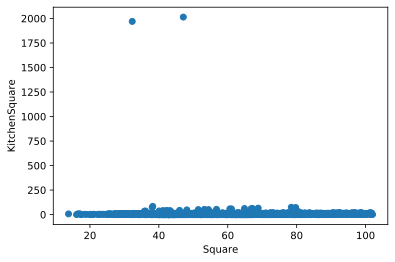

In [33]:
draw_scatter('Square', 'KitchenSquare', train_opt)

In [34]:
train_opt.loc[train_opt['KitchenSquare'] > 250].nlargest(20, 'KitchenSquare')

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1064  14656          62      1  47.100719   46.447960         2014.0      4   
8584  14679          81      1  32.276665   19.278395         1970.0      6   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1064           1       2014   0.072158         B         B         2   
8584           1       1977   0.006076         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1064       629         1           NaN            0        0       A   
8584      5285         0         645.0            6        6       B   

              Price  
1064  108337.484375  
8584  105539.554688

Well, there are 2 strange values for a KitchenSquare looks like an outliner, let's fix it too.

In [35]:
replace_by_IQ('KitchenSquare', train_opt)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.243104934692383
In 31 row KitchenSquare was replaced to 6.243104934692383.


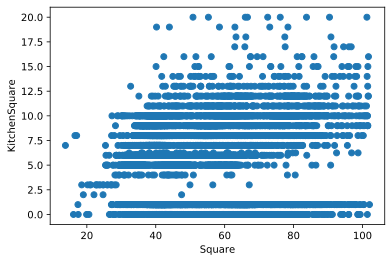

In [36]:
draw_scatter('Square', 'KitchenSquare', train_opt)

In [37]:
train_opt.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118824    34.519817   
std     4856.596405    43.768356     0.809624    15.594494    13.030704   
min        2.000000     0.000000     0.000000    13.784864     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065817   
50%     8390.500000    36.000000     2.000000    51.217516    32.871721   
75%    12591.250000    77.000000     2.000000    64.293636    43.319538   
max    16798.000000   209.000000    19.000000   102.032799    77.052979   

       KitchenSquare        Floor   HouseFloor     HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9.572000e+03  9572.000000   
mean        5.701161     8.471061    12.586293  4.079251e+03     0.119943   
std         3.773078     5.168552     6.628252  2.049338e+05     0.119591   
min         0.000000     1.000000     0.000000  1.910000e+03     0.000000   
25%         1.000000     4.000000     9.000000  1.973000e+03     0.017647   
50%         6.000000     7.000000    12.000000  1.977000e+03     0.075779   
75%         9.000000    12.000000    17.000000  1.999000e+03     0.195781   
max        20.000000    42.000000   117.000000  2.005201e+07     0.521867   

          Social_1      Social_2     Social_3  Healthcare_1  Helthcare_2  \
count  9572.000000   9572.000000  9572.000000   5025.000000  9572.000000   
mean     24.914333   5390.685959     8.029461   1147.192383     1.327518   
std      17.488685   3994.347092    23.702448   1023.039734     1.485634   
min       0.000000    168.000000     0.000000      0.000000     0.000000   
25%       6.000000   1564.000000     0.000000    350.000000     0.000000   
50%      25.000000   5285.000000     2.000000    900.000000     1.000000   
75%      36.000000   7287.000000     5.000000   1548.000000     2.000000   
max      74.000000  19083.000000   141.000000   4849.000000     6.000000   

           Shops_1          Price  
count  9572.000000    9572.000000  
mean      4.237986  209182.718750  
std       4.792616   87271.914062  
min       0.000000   59174.777344  
25%       1.000000  151904.414062  
50%       3.000000  189610.132812  
75%       6.000000  244221.527344  
max      23.000000  633233.437500

Seems like HouseFloor might have outliners. Let's have a look.

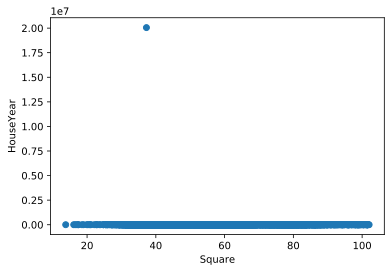

In [38]:
draw_scatter('Square', 'HouseYear', train_opt)

In [39]:
train_opt.loc[train_opt['HouseYear'] > 2025]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109      1  37.265072   20.239714            9.0      9   
4189  11607         147      2  44.791836   28.360394            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497          12   20052011   0.136330         B         B        30   
4189           9       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10         262.0            3        6       B   
4189      4756        16        2857.0            5        8       B   

              Price  
1497  254084.531250  
4189  243028.609375

In [40]:
mean_year = np.round(train_opt.loc[train_opt['HouseYear'] <= 2025, 'HouseYear'].mean())
mean_year

1984.0

In [41]:
clean_year(train_opt, mean_year)

In [42]:
train_opt.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118824    34.519817   
std     4856.596405    43.768356     0.809624    15.594494    13.030704   
min        2.000000     0.000000     0.000000    13.784864     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065817   
50%     8390.500000    36.000000     2.000000    51.217516    32.871721   
75%    12591.250000    77.000000     2.000000    64.293636    43.319538   
max    16798.000000   209.000000    19.000000   102.032799    77.052979   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean        5.701161     8.471061    12.586293  1984.285311     0.119943   
std         3.773078     5.168552     6.628252    18.135698     0.119591   
min         0.000000     1.000000     0.000000  1910.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.017647   
50%         6.000000     7.000000    12.000000  1977.000000     0.075779   
75%         9.000000    12.000000    17.000000  1999.000000     0.195781   
max        20.000000    42.000000   117.000000  2020.000000     0.521867   

          Social_1      Social_2     Social_3  Healthcare_1  Helthcare_2  \
count  9572.000000   9572.000000  9572.000000   5025.000000  9572.000000   
mean     24.914333   5390.685959     8.029461   1147.192383     1.327518   
std      17.488685   3994.347092    23.702448   1023.039734     1.485634   
min       0.000000    168.000000     0.000000      0.000000     0.000000   
25%       6.000000   1564.000000     0.000000    350.000000     0.000000   
50%      25.000000   5285.000000     2.000000    900.000000     1.000000   
75%      36.000000   7287.000000     5.000000   1548.000000     2.000000   
max      74.000000  19083.000000   141.000000   4849.000000     6.000000   

           Shops_1          Price  
count  9572.000000    9572.000000  
mean      4.237986  209182.718750  
std       4.792616   87271.914062  
min       0.000000   59174.777344  
25%       1.000000  151904.414062  
50%       3.000000  189610.132812  
75%       6.000000  244221.527344  
max      23.000000  633233.437500

Number of max rooms looks suspicious too.

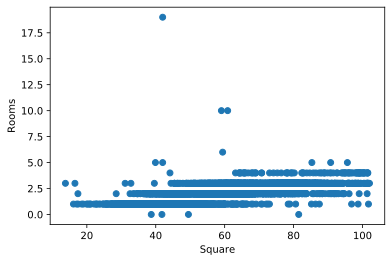

In [43]:
draw_scatter('Square', 'Rooms', train_opt)

In [44]:
train_opt.loc[train_opt['Rooms'] > 6]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
377    5927          57     10  59.056976   36.223072           10.0     22   
1454   8491           1     19  42.006046   21.779287            7.0     17   
8849  14865           9     10  60.871265   38.420681           10.0      3   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
377           22     2002.0   0.090799         B         B        74   
1454          17     2014.0   0.007122         B         B         1   
8849           2     1994.0   0.161532         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
377      19083         2           NaN            5       15       B   
1454       264         0           NaN            0        1       B   
8849      5648         1          30.0            2        4       B   

              Price  
377   317265.312500  
1454   78364.617188  
8849  172329.265625

In [45]:
mean_rooms = np.round(train_opt.loc[train_opt['Rooms'] < 6 , 'Rooms'].mean())
mean_rooms

2.0

In [46]:
replace_by_IQ('Rooms', train_opt)

For column Rooms
	IQ:	1.0
	LOW:	-0.5
	HIGH:	3.5
	MEAN:	1.8459047221061429
In 102 row Rooms was replaced to 1.8459047221061429.


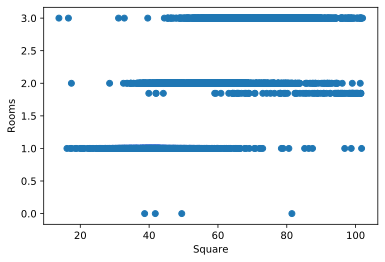

In [47]:
draw_scatter('Square', 'Rooms', train_opt)

In [48]:
train_opt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9572 non-null   uint16  
 1   DistrictId     9572 non-null   uint8   
 2   Rooms          9572 non-null   float64 
 3   Square         9572 non-null   float32 
 4   LifeSquare     9572 non-null   float32 
 5   KitchenSquare  9572 non-null   float32 
 6   Floor          9572 non-null   uint8   
 7   HouseFloor     9572 non-null   uint8   
 8   HouseYear      9572 non-null   float64 
 9   Ecology_1      9572 non-null   float32 
 10  Ecology_2      9572 non-null   category
 11  Ecology_3      9572 non-null   category
 12  Social_1       9572 non-null   uint8   
 13  Social_2       9572 non-null   uint16  
 14  Social_3       9572 non-null   uint8   
 15  Healthcare_1   5025 non-null   float32 
 16  Helthcare_2    9572 non-null   uint8   
 17  Shops_1        9572 non-null   ui

Ecology_2, Ecology_2 and Shop_2 are Dtype Category, let's fix that too.

In [49]:
obj_features = train_opt.select_dtypes(include='category').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

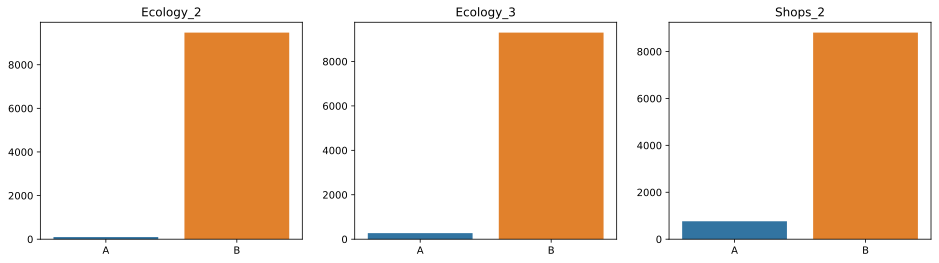

In [50]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(obj_features):
    counts = train_opt[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [51]:
for column in obj_features:
    print('{}\n'.format(train_opt[column].value_counts()))

B    9475
A      97
Name: Ecology_2, dtype: int64

B    9300
A     272
Name: Ecology_3, dtype: int64

B    8808
A     764
Name: Shops_2, dtype: int64



Let's replace the values with binary values.

In [52]:
obj_to_bool(obj_features, train_opt)

In [53]:
for column in obj_features:
    print('{}\n'.format(train_opt[column].value_counts()))

False    9475
True       97
Name: Ecology_2, dtype: int64

False    9300
True      272
Name: Ecology_3, dtype: int64

False    8808
True      764
Name: Shops_2, dtype: int64



In [54]:
train_opt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9572 non-null   uint16 
 1   DistrictId     9572 non-null   uint8  
 2   Rooms          9572 non-null   float64
 3   Square         9572 non-null   float32
 4   LifeSquare     9572 non-null   float32
 5   KitchenSquare  9572 non-null   float32
 6   Floor          9572 non-null   uint8  
 7   HouseFloor     9572 non-null   uint8  
 8   HouseYear      9572 non-null   float64
 9   Ecology_1      9572 non-null   float32
 10  Ecology_2      9572 non-null   bool   
 11  Ecology_3      9572 non-null   bool   
 12  Social_1       9572 non-null   uint8  
 13  Social_2       9572 non-null   uint16 
 14  Social_3       9572 non-null   uint8  
 15  Healthcare_1   5025 non-null   float32
 16  Helthcare_2    9572 non-null   uint8  
 17  Shops_1        9572 non-null   uint8  
 18  Shops_2 

In [55]:
df_num_features = train_opt.select_dtypes(include=['float64', 'float32', 'uint8', 'uint16'])

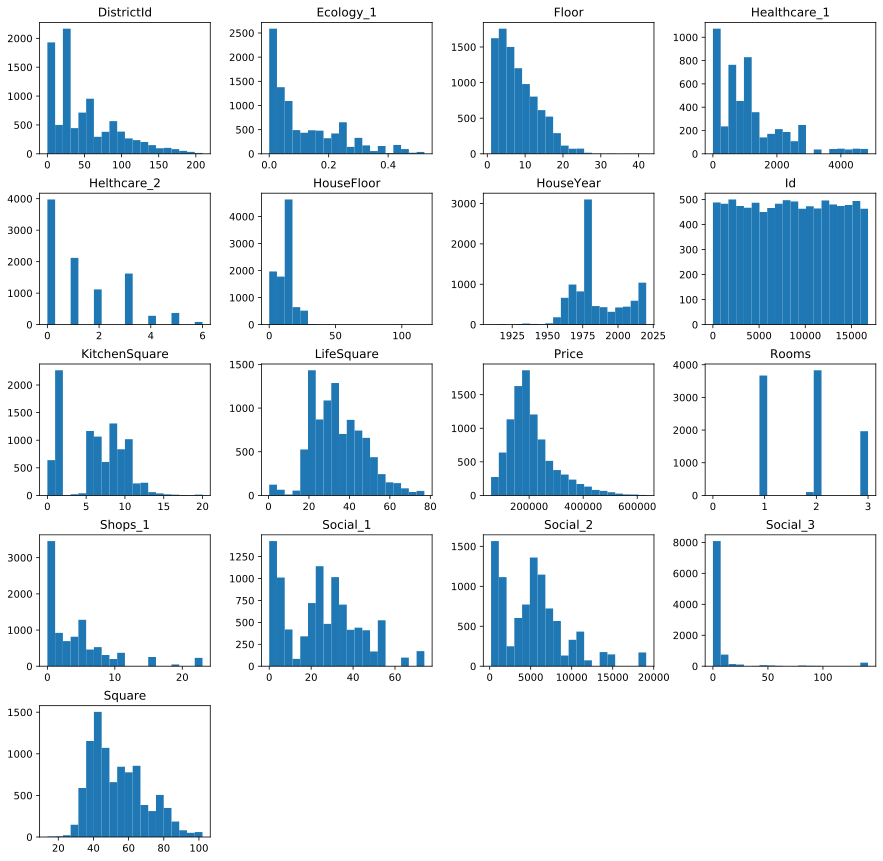

In [56]:
df_num_features.hist(figsize=(15,15), bins=20, grid=False);

Healthcare_1 looks very suspicious by having way too many values missing. Let's exclude it.

In [57]:
train_opt.drop(['Healthcare_1'], axis=1, inplace=True)

In [58]:
train_opt.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.819398    54.118824    34.519817   
std     4856.596405    43.768356     0.747036    15.594494    13.030704   
min        2.000000     0.000000     0.000000    13.784864     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065817   
50%     8390.500000    36.000000     2.000000    51.217516    32.871721   
75%    12591.250000    77.000000     2.000000    64.293636    43.319538   
max    16798.000000   209.000000     3.000000   102.032799    77.052979   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean        5.701161     8.471061    12.586293  1984.285311     0.119943   
std         3.773078     5.168552     6.628252    18.135698     0.119591   
min         0.000000     1.000000     0.000000  1910.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.017647   
50%         6.000000     7.000000    12.000000  1977.000000     0.075779   
75%         9.000000    12.000000    17.000000  1999.000000     0.195781   
max        20.000000    42.000000   117.000000  2020.000000     0.521867   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9572.000000   9572.000000  9572.000000  9572.000000  9572.000000   
mean     24.914333   5390.685959     8.029461     1.327518     4.237986   
std      17.488685   3994.347092    23.702448     1.485634     4.792616   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5285.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

               Price  
count    9572.000000  
mean   209182.718750  
std     87271.914062  
min     59174.777344  
25%    151904.414062  
50%    189610.132812  
75%    244221.527344  
max    633233.437500

### Test

In [59]:
test_opt = pd.read_csv(TEST_DATASET_PATH)
obj_to_bool(obj_features, test_opt)
replace_by_IQ('Square', test_opt)
replace_by_IQ('LifeSquare', test_opt)
fill_life_square(test_opt, square_coeff)
replace_by_IQ('Rooms', test_opt)
replace_by_IQ('KitchenSquare', test_opt)
test_opt.drop(['Healthcare_1'], axis=1, inplace=True)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.44950036381242
In 110 row Square was replaced to 56.44950036381242.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.15881045508672
In 118 row LifeSquare was replaced to 36.15881045508672.
For column Rooms
	IQ:	1.0
	LOW:	-0.5
	HIGH:	3.5
	MEAN:	1.91
In 100 row Rooms was replaced to 1.91.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


In [60]:
test_opt.describe()

Id   DistrictId      Rooms       Square   LifeSquare  \
count   5000.000000  5000.000000  5000.0000  5000.000000  5000.000000   
mean    8412.595400    51.279200     1.8634    55.174352    35.040790   
std     4832.674037    44.179466     0.7462    16.124072    13.322259   
min        1.000000     0.000000     0.0000     5.647458     0.333490   
25%     4221.750000    21.000000     1.0000    41.928216    24.667451   
50%     8320.500000    37.000000     2.0000    53.011662    33.674583   
75%    12598.250000    77.000000     2.0000    65.394081    43.586795   
max    16795.000000   212.000000     3.0000   102.781220    78.281763   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean        5.693912     8.632000    12.601000  1984.392600     0.119874   
std         3.805523     5.483228     6.789213    18.573149     0.120070   
min         0.000000     1.000000     0.000000  1908.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.019509   
50%         6.000000     7.000000    12.000000  1977.000000     0.072158   
75%         9.000000    12.000000    17.000000  2000.000000     0.195781   
max        20.000000    78.000000    99.000000  2020.000000     0.521867   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  
count  5000.000000   5000.000000  5000.000000   5000.00000  5000.000000  
mean     24.933800   5406.900000     8.262600      1.31940     4.242800  
std      17.532202   4026.614773    23.863762      1.47994     4.777365  
min       0.000000    168.000000     0.000000      0.00000     0.000000  
25%       6.000000   1564.000000     0.000000      0.00000     1.000000  
50%      25.000000   5285.000000     2.000000      1.00000     3.000000  
75%      36.000000   7287.000000     5.000000      2.00000     6.000000  
max      74.000000  19083.000000   141.000000      6.00000    23.000000

### Building a model, data processing

In [61]:
print(train_opt.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [62]:
features = train_opt.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [63]:
test_opt[features].head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   44.179644            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199      False      False        11      2748         1            0   
1   0.075779      False      False         6      1437         3            0   
2   0.000000      False      False        30      7538        87            5   
3   0.101872      False      False        23      4583         3            3   
4   0.072158      False      False         2       629         1            0   

   Shops_1  Shops_2  
0        0    False  
1        2    False  
2        5    False  
3        3    False  
4        0     True

In [64]:
X = pd.DataFrame(train_opt, columns=features)
y = pd.DataFrame(train_opt, columns=[target])

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
X_test = test_opt[features]
X_test.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   44.179644            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199      False      False        11      2748         1            0   
1   0.075779      False      False         6      1437         3            0   
2   0.000000      False      False        30      7538        87            5   
3   0.101872      False      False        23      4583         3            3   
4   0.072158      False      False         2       629         1            0   

   Shops_1  Shops_2  
0        0    False  
1        2    False  
2        5    False  
3        3    False  
4        0     True

In [67]:
scaler = StandardScaler()

In [68]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

In [69]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float64
 1   Square         5000 non-null   float64
 2   LifeSquare     5000 non-null   float64
 3   KitchenSquare  5000 non-null   float64
 4   Floor          5000 non-null   int64  
 5   HouseFloor     5000 non-null   float64
 6   HouseYear      5000 non-null   int64  
 7   Ecology_1      5000 non-null   float64
 8   Ecology_2      5000 non-null   bool   
 9   Ecology_3      5000 non-null   bool   
 10  Social_1       5000 non-null   int64  
 11  Social_2       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  Shops_2        5000 non-null   bool   
dtypes: bool(3), float64(6), int64(7)
memory usage: 522.6 KB


In [70]:
X_train.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
1491    2.0  42.822693   29.711275            5.0      5           5   
5119    1.0  33.383335   24.847544            5.0      1           5   
2680    2.0  43.158417   28.495710            5.0      2           5   
9729    1.0  42.266106   26.959511            1.0     19          17   
1950    1.0  41.172699   20.052042            8.0     14          17   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
1491     1958.0   0.327018      False      False        12      2270   
5119     1965.0   0.200147      False      False        23      3975   
2680     1962.0   0.038693      False      False        28      6533   
9729     1977.0   0.075779      False      False         6      1437   
1950     1995.0   0.041116      False      False        53     14892   

      Social_3  Helthcare_2  Shops_1  Shops_2  
1491        23            1        0    False  
5119         8            2        0    False  
2680         1            2        5    False  
9729         3            0        2    False  
1950         4            1        4    False

In [71]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


r2_train = 0.8164010415880526, mae_train: 24478.821244037666
r2_test = 0.6794589061849374, mae_test: 30148.133349122185


In [72]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test_opt['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)